In [1]:
from __future__ import print_function

import sys
import json
import pickle
import threading
from operator import mul
from copy import deepcopy
from functools import reduce

import keras
import theano
import theano.tensor as T
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Merge, Input, Lambda, merge, Layer, BatchNormalization

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

#from ddpg import Actor, Critic
from naf.priority_buffer import PriorityBuffer
from environment import Environment, WIN, LOSE, NEUTRAL

Using Theano backend.


In [2]:
MAX_DIST = 0.01

-0.553494813406


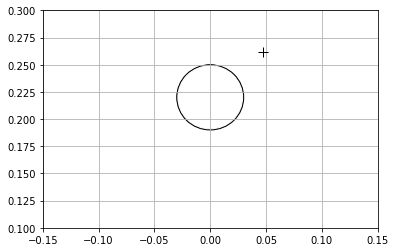

In [36]:
import numpy as np

WIN = 0
LOSE = 1
NEUTRAL = 2
MAX_DIST = 0.01


def create_state_vector(eef_x, eef_y, circle_x, circle_y, goal_x, goal_y):
    return np.array([
        [eef_x, eef_y, circle_x, circle_y, goal_x, goal_y]
    ], dtype=np.float32)


class Circle:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.radius = 0.03
        
    def interact(self, x, y):
        theta = np.arctan2(y - self.y, x - self.x)
        center_distance = np.linalg.norm([self.y - y, self.x - x])
        distance = self.radius - center_distance
        if center_distance > self.radius:
            return
        self.x -= distance * np.cos(theta)
        self.y -= distance * np.sin(theta)


class Environment:
    
    def __init__(self, max_dist):
        self.max_dist = max_dist
        self.reset()
    
    def reset(self):
        # Random on inner and outer circle
        circle_x = 0.30 * np.random.rand() - 0.15
        circle_y = 0.18 * np.random.rand() + 0.11
        self.goal_x = 0.00
        self.goal_y = 0.22
        #self.circle = Circle(circle_x, circle_y)
        self.circle = Circle(0.0, 0.22)
        eef_theta = np.random.rand() * 2 * np.pi
        self.eef_x = circle_x
        self.eef_y = circle_y
        while np.linalg.norm([self.eef_x - circle_x, self.eef_y - circle_y]) < 0.03:
            self.eef_x = 0.30 * np.random.rand() - 0.15
            self.eef_y = 0.18 * np.random.rand() + 0.11

    def get_state(self):
        return create_state_vector(
            self.eef_x,
            self.eef_y,
            self.circle.x,
            self.circle.y,
            self.goal_x,
            self.goal_y,
        )

    def interact(self, dx, dy):
        dist = np.linalg.norm([dx, dy])
        if dist > self.max_dist:
            dx = self.max_dist * dx / dist
            dy = self.max_dist * dy / dist
        self.eef_x += dx
        self.eef_y += dy
        #self.circle.interact(self.eef_x, self.eef_y)
        state = NEUTRAL
        reward = -4
        if not -0.15 <= self.eef_x <= 0.15:
            state = LOSE
        elif not 0.10 <= self.eef_y <= 0.30:
            state = LOSE
        #elif not -0.15 <= self.circle.x <= 0.15:
        #    state = LOSE
        #elif not 0.10 <= self.circle.y <= 0.30:
        #    state = LOSE
        elif np.linalg.norm([self.goal_x - self.circle.x, self.goal_y - self.circle.y]) < 0.005:
            state = WIN
            
        if state != LOSE:
            eef2circle = np.linalg.norm([self.eef_x - self.circle.x, self.eef_y - self.circle.y])
            circle2goal = np.linalg.norm([self.goal_x - self.circle.x, self.goal_y - self.circle.y])
            eef2goal = np.linalg.norm([self.eef_x - self.goal_x, self.eef_y - self.goal_y])
            reward = (
                #np.exp(-200 * eef2circle ** 2) - 1 +
                #2 * (np.exp(-200 * circle2goal ** 2) - 1)
                np.exp(-200 * eef2goal ** 2) - 1
            )
        
        return state, reward, self.get_state()
    
    def heuristic_move(self):
        e = self
        a = np.array([e.eef_x, e.eef_y])
        b = np.array([e.circle.x, e.circle.y])
        d = b - a
        d_norm = np.linalg.norm(d)
        theta = np.arcsin(self.circle.radius / d_norm)
        A = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        xa = np.dot(A, d) * np.sqrt(d_norm ** 2 - self.circle.radius ** 2) / d_norm
        xb = np.dot(A.T, d) * np.sqrt(d_norm ** 2 - self.circle.radius ** 2) / d_norm

        fg = np.array([e.goal_x, e.goal_y])
        if np.linalg.norm(fg - b) < 0.0005:
            return np.zeros(2)
        pd = (fg - b) / np.linalg.norm(fg - b) # pushing direction
        pg = b - pd * self.circle.radius       # pushing goal
        e_dist = np.linalg.norm(xa)
        a_dist = np.linalg.norm(pg - a - xa)
        b_dist = np.linalg.norm(pg - a - xb)
        pg_dist = np.linalg.norm(a - pg)
        if pg_dist < 0.005:
            return min(self.max_dist, d_norm) * pd
        if 0.005 < e_dist < pg_dist:
            if a_dist < b_dist:
                return min(self.max_dist, np.linalg.norm(xa)) * xa / np.linalg.norm(xa)
            else:
                return min(self.max_dist, np.linalg.norm(xb)) * xb / np.linalg.norm(xb)
        else:
            return min(self.max_dist, np.linalg.norm(pg - a)) * (pg - a) / np.linalg.norm(pg - a)


    def plot(self, ax=None):
        import matplotlib.pyplot as plt
        if ax is None:
            _, ax = plt.subplots()
        plt.grid()
        ax.add_artist(plt.Circle(
            (self.goal_x, self.goal_y),
            self.circle.radius,
            color='k',
        ))
        ax.add_artist(plt.Circle(
            (self.goal_x, self.goal_y),
            self.circle.radius - 0.001,
            color='w',
        ))
        #ax.add_artist(plt.Circle(
        #    (self.circle.x, self.circle.y),
        #    self.circle.radius,
        #    color='r',
        #    alpha=0.5
        #))
        plt.plot(self.eef_x, self.eef_y, 'k+', markersize=10)
        plt.xlim((-0.15, 0.15))
        plt.ylim((0.10, 0.30))


e = Environment(MAX_DIST)
s, r, sr = e.interact(-0.01, 0.00)
print(r)
e.plot()
plt.show()

In [391]:
def gauss_loss(seq_len):
    def f(y_true, y_pred):
        batch_size = y_true.shape[0]
        log_probs = T.zeros((batch_size, seq_len))
        rewards = y_true[:, 3 * seq_len: 4 * seq_len]
        for t in range(seq_len):
            mu = y_pred[:, 2 * t: 2 * t + 2]
            sigma = y_pred[:, 2 * seq_len + 2 * t: 2 * seq_len + 2 * t + 2]
            u = y_true[:, 2 * t: 2 * t + 2]
            sample_prob = y_true[:, 2 * seq_len + t: 2 * seq_len + t + 1]
            reward = y_true[:, 3 * seq_len + t: 3 * seq_len + t + 1]
            Z = T.sqrt(4 * np.pi * sigma.prod(axis=1, keepdims=True))
            Zloginv = -1/2 * T.log(sigma).sum(axis=1, keepdims=True)
            explog = -1/2 * ((u - mu) ** 2 / sigma).sum(axis=1, keepdims=True)
            p = Zloginv + explog - T.log(sample_prob)
            log_probs = T.set_subtensor(log_probs[:, t:t + 1], p)
            log_probs -= log_probs.max(axis=0, keepdims=True)
        probs = T.exp(log_probs)
        probs /= probs.sum(axis=0, keepdims=True)
        probs *= (-rewards)
        return probs.sum()
    return f

#np.random.seed(1)
gl = gauss_loss(seq_len)
batch_size = 4096
seq_len = 4
xs = np.zeros((batch_size, 2 * seq_len))
thetas = 2 * np.pi * np.random.rand(batch_size)
xs[:, :2] = 4 * np.array([np.cos(thetas - np.pi), np.sin(thetas - np.pi)]).T
for i in range(1, seq_len):
    xs[:, 2*i:2*i + 2] = (seq_len - i) * xs[:, 0:2] / seq_len

y_pred = np.zeros((batch_size, (2 + 2) * seq_len)) + 1e-5 # sigma added here

for n in range(batch_size):
    for i in range(seq_len):
        x = xs[n, 2 * i:2 * i + 2]
        u = -x / (4 - i)
        y_pred[n, 2 * i:2 * i + 2] = u

y_true = np.zeros((batch_size, 2 * seq_len + 2 * seq_len))
for n in range(batch_size):
    for i in range(seq_len):
        x = xs[n, 2 * i:2 * i + 2]
        u = np.random.randn(2) * 0.5
        prob = multivariate_normal.pdf(u, mean=[0, 0])
        reward = -np.linalg.norm(x + u)
        y_true[n, 2 * i:2 * i + 2] = u
        y_true[n, 2 * seq_len + i] = prob
        y_true[n, 3 * seq_len + i] = reward
    
gl(y_true, y_pred).eval()

array(6.019837306967091)

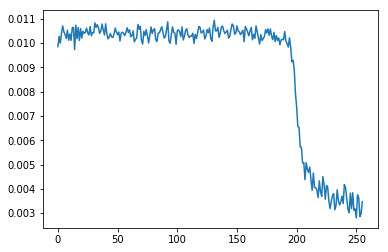

Epoch 1/1
512/512 [==============================] - 0s - loss: 0.0030     


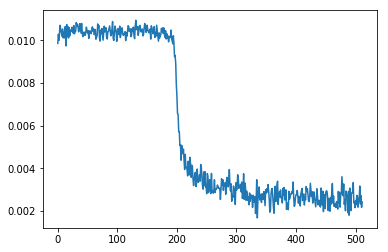

Epoch 1/1
512/512 [==============================] - 0s - loss: 0.0021     


KeyboardInterrupt: 

In [6]:
class TryOutNN:
    
    def __init__(self, x_size, hidden_size=100):
        
        x = Input(shape=(x_size, ))
        
        shared = Sequential([
            Dense(input_dim=x_size, output_dim=hidden_size, name='fc1', activation='relu'),
            Dense(output_dim=hidden_size, name='fc2', activation='relu'),
        ])(x)
        
        mu = Sequential([
            Dense(input_dim=hidden_size, output_dim=2, activation='tanh', name='mu'),
            Lambda(lambda x: 0.01 * x, output_shape=(2, )),
        ])(shared)

        sigma = Dense(output_dim=2, activation='sigmoid', name='sigma')(shared)
        sigma = Sequential([
            Dense(input_dim=hidden_size, output_dim=2, activation='sigmoid', name='sigma'),
            Lambda(lambda x: 0.01 * x, output_shape=(2, )),
        ])(shared)
        
        model = Model(input=x, output=merge([mu, sigma], mode='concat'))

        adam = Adam(lr=1e-4)
        model.compile(optimizer=adam, loss=gauss_loss())
        self.model = model
        self.predict = model.predict
    
    def fit(self, X, controls, probabilities, rewards, **kwargs):
        Y = np.hstack([controls, rewards, probabilities])
        return self.model.fit(X, Y, **kwargs)
        
nn = TryOutNN(2)
losses = []
for i in range(1024):
    x = 0.02 * np.random.rand(512, 2) - 0.01
    controls = 0.02 * np.random.rand(512, 2) - 0.01
    probabilities = np.ones((512, 1))
    rewards = -np.linalg.norm(controls + x, axis=1, keepdims=True)
    verbose = 0
    if i % 256 == 0 and i > 0:
        verbose = 1
        plt.plot(losses)
        plt.show()
    history = nn.fit(x, controls + np.random.randn(512, 1) * 1e-3, probabilities, rewards, nb_epoch=1, verbose=verbose)
    losses.append(history.history['loss'])

In [828]:
x = np.random.randn(512, 2) * 0.01
np.hstack([x, nn.predict(x)[:, :2]])

array([[ 0.0012376 ,  0.0060784 , -0.00216873, -0.00693875],
       [ 0.00238842,  0.00117087, -0.00350661, -0.00266489],
       [-0.00182158, -0.00658037,  0.00127178,  0.00569236],
       ..., 
       [ 0.00052187,  0.02026791, -0.00205319, -0.00947402],
       [ 0.00562545,  0.01226391, -0.00608393, -0.008854  ],
       [-0.00861664,  0.00029921,  0.0074205 , -0.0016852 ]])

In [38]:
#nn = TryOutNN(4)
batch_size = 2048
n_iterations = 128
e.reset()
for n in range(n_iterations):
    X = []
    controls = []
    rewards = []
    probs = []
    for i in range(batch_size):
        x = e.get_state()[:, :4]
        X.append(x.flatten())
        y = nn.predict(x)
        mu = y[:, :2]
        sigma = y[:, 2:4]
        u = np.random.multivariate_normal(mu.flatten(), np.diag(sigma.flatten()))
        prob = multivariate_normal.pdf(u.flatten(), mean=mu.flatten(), cov=np.diag(sigma.flatten()))
        state, reward, _ = e.interact(*u)
        if state == LOSE:
            e.reset()
        controls.append(u)
        rewards.append([reward])
        probs.append([prob])
    nn.fit(
        np.array(X),
        np.array(controls),
        np.array(probs),
        np.array(rewards) + np.random.randn(batch_size, 1) * 1e-4,
        nb_epoch=1,
        verbose=n % 16 == 0
    )

Epoch 1/1
2048/2048 [==============================] - 0s - loss: 0.5254     

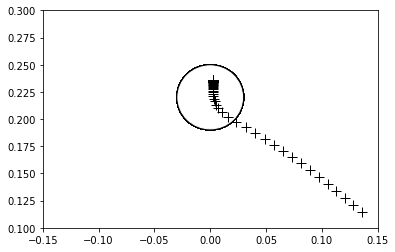

In [56]:
fig, ax = plt.subplots()
e.reset()
for i in range(64):
    e.plot(ax=ax)
    u = nn.predict(e.get_state()[:, :4])
    dx, dy = u[0, :2]
    e.interact(dx, dy)
plt.show()

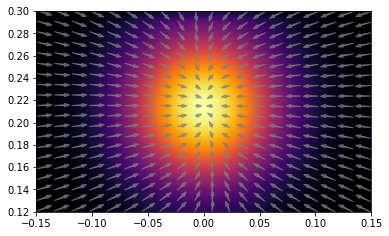

In [979]:
def plot_r(nn, e):
    res = 30
    x_min, x_max = -0.15, 0.15
    y_min, y_max =  0.12, 0.30
    xs = np.linspace(x_min, x_max, res)
    ys = np.linspace(y_min, y_max, res)
    zs = np.zeros((res, res))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            eef2goal = np.linalg.norm([x - e.goal_x, y - e.goal_y])
            zs[-j, i] = np.exp(-200 * eef2goal ** 2) - 1
    plt.imshow(
        zs,
        cmap='inferno',
        interpolation='gaussian',
        extent=[x_min, x_max, y_min, y_max]
    )
    policy_res = 20
    xs = np.linspace(x_min, x_max, policy_res)
    ys = np.linspace(y_min, y_max, policy_res)
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            dx, dy = nn.predict(np.array([[x, y, e.goal_x, e.goal_y]]))[0, :2]
            plt.arrow(x, y, dx, dy, color='grey', alpha=0.7)
    plt.xlim((x_min, x_max))
    plt.ylim((y_min, y_max))

def plot_pi(nn, e):
    x_min, x_max = -0.15, 0.15
    y_min, y_max =  0.12, 0.30
    

plot_r(nn, e)
plt.savefig('policy-search-immediate-reward.pdf')
plt.show()

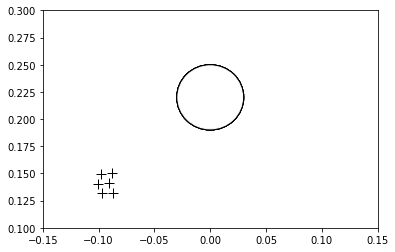

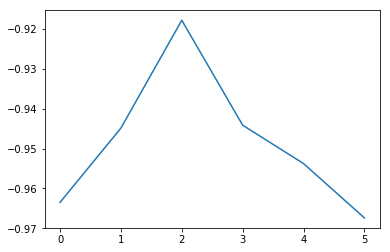

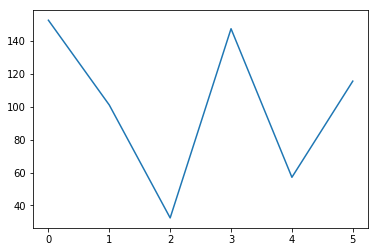

Epoch 1/10
256/256 [==============================] - 0s - loss: 0.1732     
Epoch 2/10
256/256 [==============================] - 0s - loss: 0.1723     
Epoch 3/10
256/256 [==============================] - 0s - loss: 0

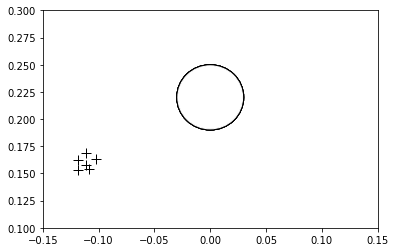

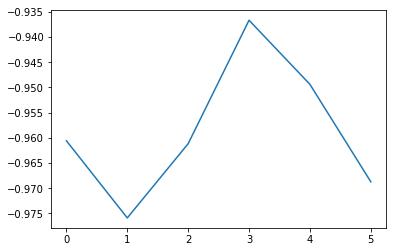

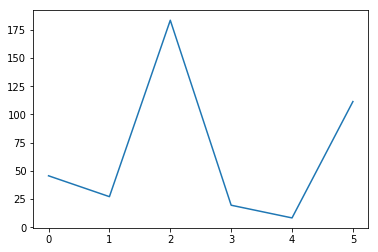

Epoch 1/10
512/512 [==============================] - 0s - loss: 0.1719     
Epoch 2/10
512/512 [==============================] - 0s - loss: 0.1710     

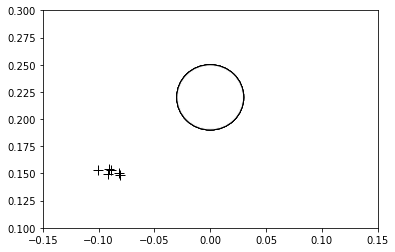

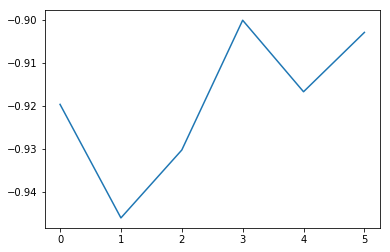

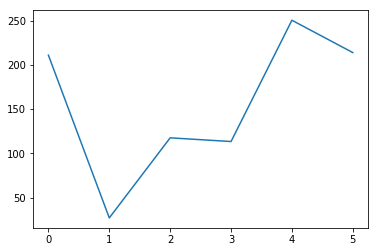

Epoch 1/10
768/768 [==============================] - 0s - loss: 0.1701     
Epoch 2/10
76

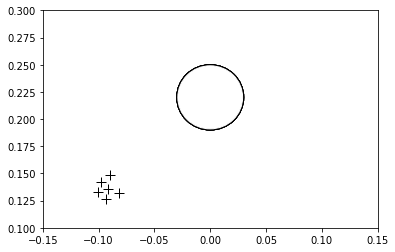

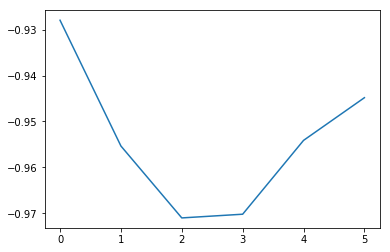

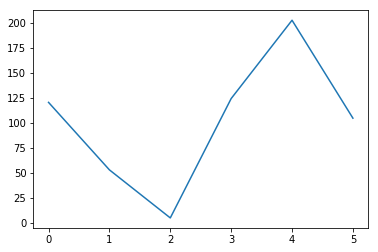

Epoch 1/10
1024/1024 [==============================] - 0s - loss: 0.1698     

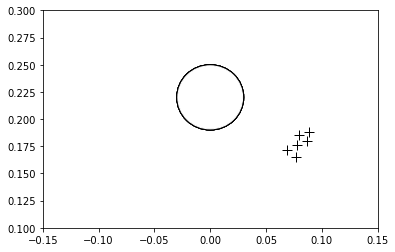

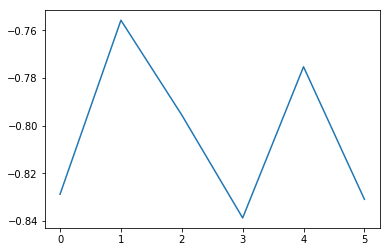

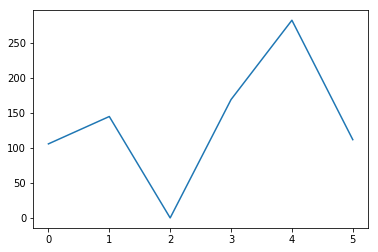

Epoch 1/10
1280/1280 [==============================] - 0s - loss: 0.1701     

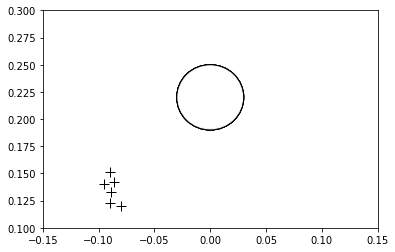

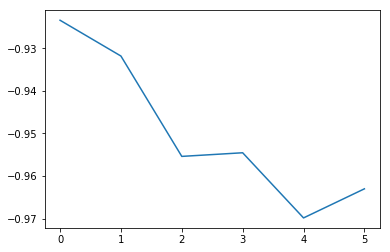

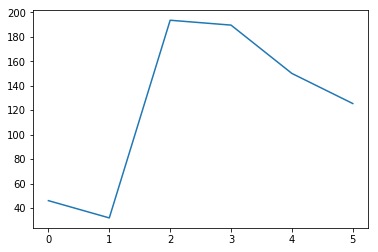

Epoch 1/10
1536/1536 [==============================] - 1s - loss: 0.1699     

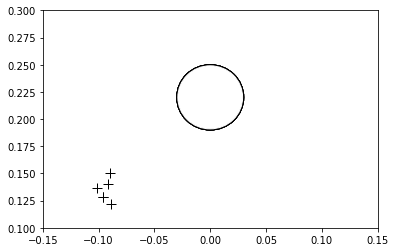

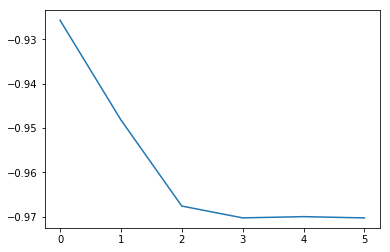

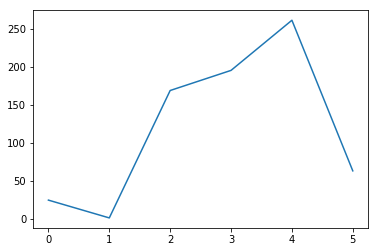

Epoch 1/10
1792/1792 [==============================] - 1s - loss: 0.1698     

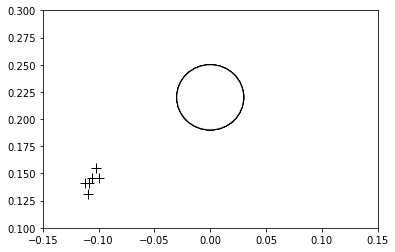

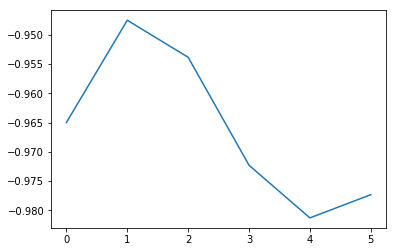

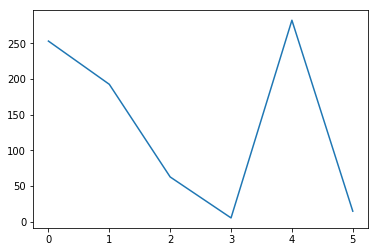

Epoch 1/10
2048/2048 [==============================] - 1s - loss: 0.1701     

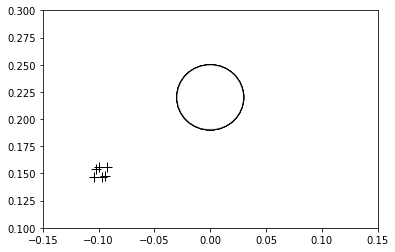

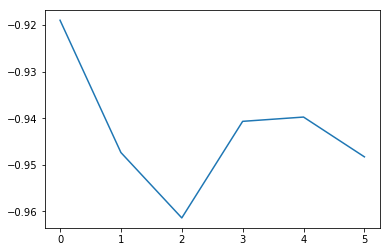

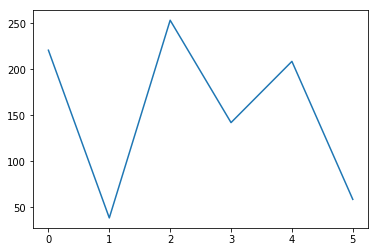

Epoch 1/10
2304/2304 [==============================] - 1s - loss: 0.1698     

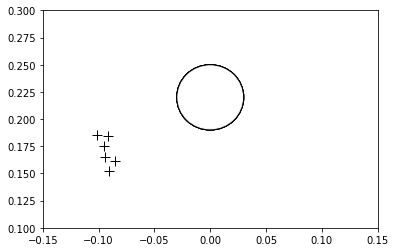

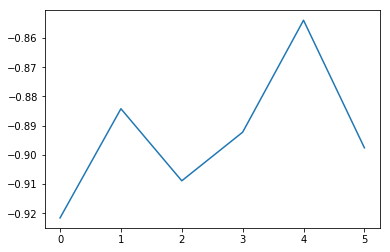

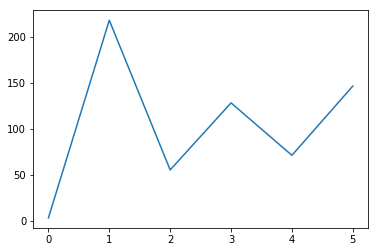

Epoch 1/10
2560/2560 [==============================] - 1s - loss: 0.1702     

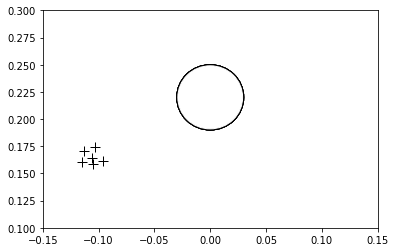

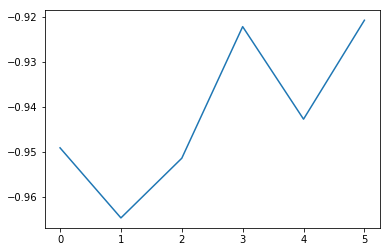

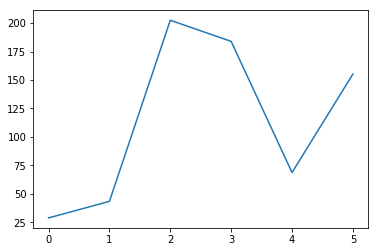

Epoch 1/10
2816/2816 [==============================] - 1s - loss: 0.1701     

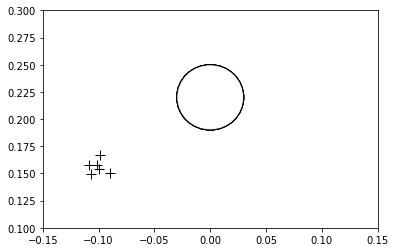

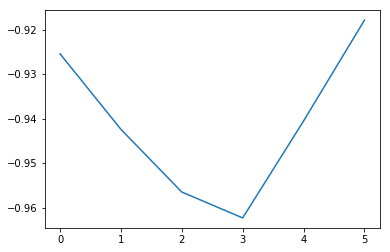

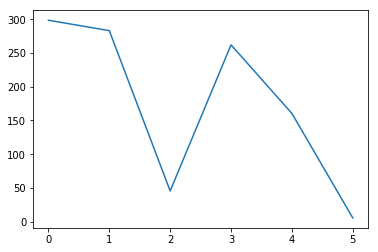

Epoch 1/10
3072/3072 [==============================] - 1s - loss: 0.1704     

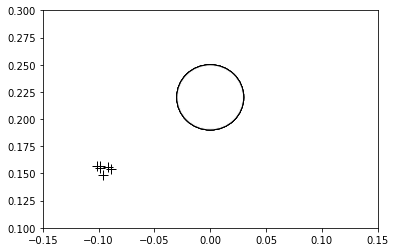

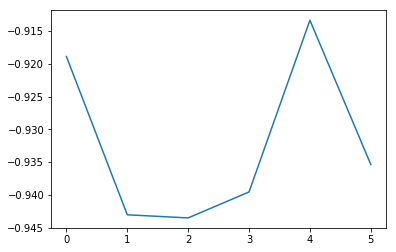

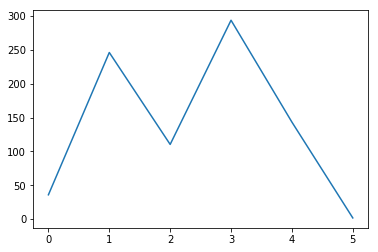

Epoch 1/10
3328/3328 [==============================] - 1s - loss: 0.1700     

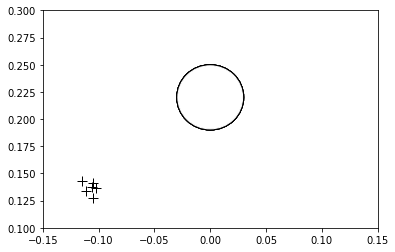

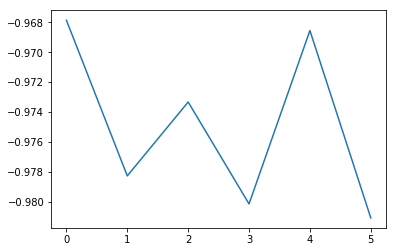

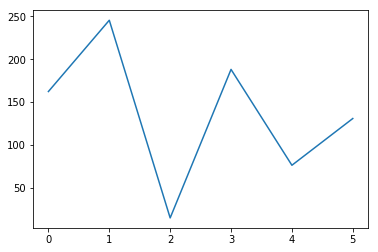

Epoch 1/10
3584/3584 [==============================] - 1s - loss: 0.1697     

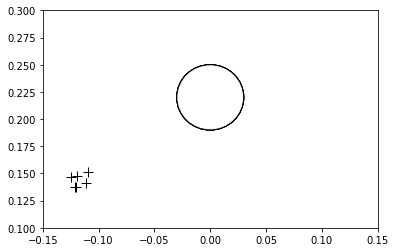

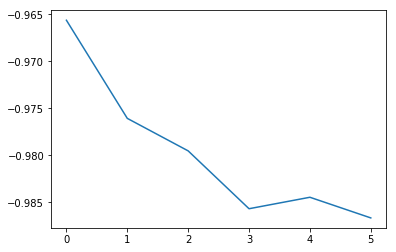

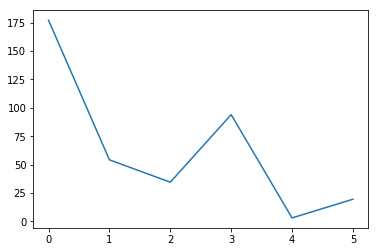

Epoch 1/10
3840/3840 [==============================] - 1s - loss: 0.1704     

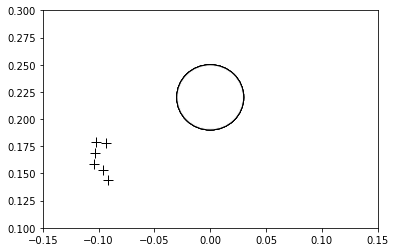

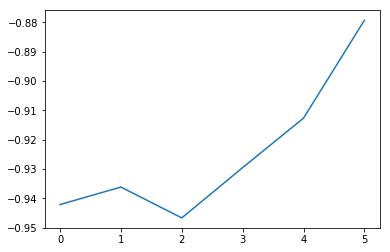

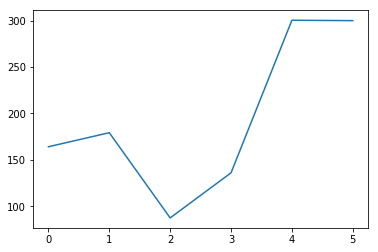

Epoch 1/10
4096/4096 [==============================] - 1s - loss: 0.1703     

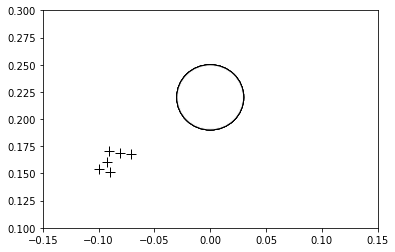

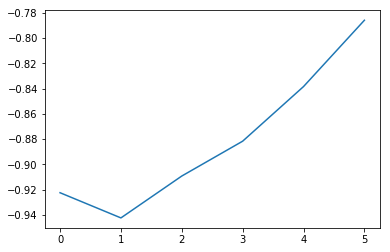

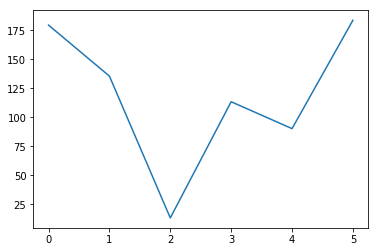

Epoch 1/10
4352/4352 [==============================] - 2s - loss: 0.1701     

KeyboardInterrupt: 

In [113]:
X = []
Y = []

nn = NN(
    x_size=6,
    u_size=u_size,
    n_mixtures=n_mixtures,
    seq_len=seq_len,
    mu_scaling=0.01,
    sigma_scaling=0.02 ** 2,
    hidden_size=100
)

n_iterations = 512
for iteration in range(n_iterations):
    for i in range(256):
        x, y = run_trial(e, nn, seq_len)
        X.append(x)
        Y.append(y)
    nn.fit(X, Y)
    run_trial(e, nn, seq_len, plot=True)

In [81]:
%debug

> /usr/local/lib/python3.6/site-packages/scipy/stats/_multivariate.py(155)__init__()
    153         d = s[s > eps]
    154         if len(d) < len(s) and not allow_singular:
--> 155             raise np.linalg.LinAlgError('singular matrix')
    156         s_pinv = _pinv_1d(s, eps)
    157         U = np.multiply(u, np.sqrt(s_pinv))

ipdb> d
array([ 0.0003505])
ipdb> s
array([  1.65443653e-16,   3.50497372e-04])
ipdb> up
> /usr/local/lib/python3.6/site-packages/scipy/stats/_multivariate.py(504)pdf()
    502         dim, mean, cov = self._process_parameters(None, mean, cov)
    503         x = self._process_quantiles(x, dim)
--> 504         psd = _PSD(cov, allow_singular=allow_singular)
    505         out = np.exp(self._logpdf(x, mean, psd.U, psd.log_pdet, psd.rank))
    506         return _squeeze_output(out)

ipdb> cov
array([[  1.65443653e-16,   0.00000000e+00],
       [  0.00000000e+00,   3.50497372e-04]])
--KeyboardInterrupt--
ipdb> exit
